# Lesson 6 Demo: Exploring Transformer Components with HuggingFace

**Estimated Time:** 8 minutes

## Scenario: Content Moderation with Transformers

Your content moderation system must process **millions of user comments in real-time**. Sequential RNN processing is too slow—you can't wait for 100 time steps to process a 100-word comment.

**Solution:** Transformers process all words **simultaneously** using self-attention, achieving both speed and quality. Plus, you can leverage models pretrained on billions of words!

---

## What We'll Discover

1. ✅ **Self-attention mechanism** - Every word attends to every other word simultaneously
2. ✅ **Multi-head attention** - Different heads learn different relationships (syntax, semantics)
3. ✅ **Positional encoding** - How Transformers know word order without recurrence
4. ✅ **Parallel computation** - All positions processed simultaneously (vs. sequential RNN)
5. ✅ **Transfer learning power** - Loading pretrained models with millions of parameters

---

## Setup

In [1]:
# Install required packages (run once)
# !pip install transformers torch matplotlib seaborn numpy scikit-learn

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Import our utilities
from data import SyntheticCommentGenerator
from attention_utils import (
    plot_attention_heatmap,
    plot_multihead_attention,
    plot_layer_progression,
    compare_embeddings,
    extract_attention_patterns,
    print_attention_patterns,
    print_model_architecture,
    visualize_embedding_comparison
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("\n✓ Setup complete!")

Using device: cpu

✓ Setup complete!


---

# Part 1: Load Pretrained BERT (1 minute)

We're loading **BERT-base-uncased**:
- Trained on 3.3 billion words (English Wikipedia + BookCorpus)
- **110 million parameters**
- Would take **weeks** to train ourselves!

This is the power of **transfer learning** 🚀

In [2]:
print("Loading BERT model and tokenizer...")
print("(First run: downloads ~440MB, subsequent runs: loads from cache)\n")

# Load pretrained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.to(device)
model.eval()  # Set to evaluation mode

print("✓ BERT loaded successfully!")
print(f"✓ Model: {model_name}")
print(f"✓ Parameters: ~110M")
print(f"✓ Device: {device}")

Loading BERT model and tokenizer...
(First run: downloads ~440MB, subsequent runs: loads from cache)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✓ BERT loaded successfully!
✓ Model: bert-base-uncased
✓ Parameters: ~110M
✓ Device: cpu


---

# Part 2: Inspect Architecture (1 minute)

Let's examine what we just loaded!

In [3]:
# Print detailed architecture
print_model_architecture(model, detailed=True)

BERT MODEL ARCHITECTURE

Model: BERT
Architecture: BertModel

📊 Key Parameters:
  • Vocabulary size:    30,522
  • Hidden size:        768
  • Number of layers:   12
  • Attention heads:    12
  • Intermediate size:  3072
  • Max position:       512

🔢 Parameters:
  • Total:      109,482,240
  • Trainable:  109,482,240
  • Size:       ~109.5M parameters

🏗️  Layer Structure:
  Embeddings:
    ├── Token Embeddings:     30522 × 768
    ├── Position Embeddings:  512 × 768
    └── Layer Normalization

  Transformer Layers (×12):
    ├── Multi-Head Attention:
    │   ├── Heads: 12
    │   ├── Head dim: 64
    │   └── Output: 768
    ├── Feed-Forward:
    │   ├── Intermediate: 3072
    │   └── Output: 768
    └── Layer Normalization (×2)

  Output:
    └── Pooler: 768 → 768



**Key Observations:**
- 12 transformer layers
- 12 attention heads per layer = **144 attention mechanisms!**
- 768-dimensional embeddings
- Each head can learn different patterns (syntax, semantics, coreference)

---

# Part 3: Tokenize and Examine Input (1 minute)

Let's process our key example: **"The bank can refuse to lend money to the person by the river bank."**

Notice the word **"bank"** appears twice with different meanings!

In [4]:
# Get demo examples
generator = SyntheticCommentGenerator()
demo_examples = generator.get_demo_examples()

# Our key example
example_text = demo_examples['contextualized_embedding']
print("Example Text:")
print(f"  '{example_text}'")
print()

# Tokenize
inputs = tokenizer(example_text, return_tensors='pt', add_special_tokens=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print("Tokenization:")
print(f"  Tokens: {tokens}")
print(f"  Input IDs: {inputs['input_ids'][0].tolist()}")
print()

# Examine position IDs
print("Positional Encoding:")
if 'position_ids' in inputs:
    print(f"  Position IDs: {inputs['position_ids'][0].tolist()}")
else:
    # Create default position IDs
    seq_len = inputs['input_ids'].shape[1]
    position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0)
    print(f"  Position IDs: {position_ids[0].tolist()}")

print()
print("💡 Key Insight:")
print("   Transformers need position_ids because they process all tokens in parallel.")
print("   Unlike RNNs, there's no inherent sequence order!")

Example Text:
  'The bank can refuse to lend money to the person by the river bank.'

Tokenization:
  Tokens: ['[CLS]', 'the', 'bank', 'can', 'refuse', 'to', 'lend', 'money', 'to', 'the', 'person', 'by', 'the', 'river', 'bank', '.', '[SEP]']
  Input IDs: [101, 1996, 2924, 2064, 10214, 2000, 18496, 2769, 2000, 1996, 2711, 2011, 1996, 2314, 2924, 1012, 102]

Positional Encoding:
  Position IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

💡 Key Insight:
   Transformers need position_ids because they process all tokens in parallel.
   Unlike RNNs, there's no inherent sequence order!


---

# Part 4: Extract Contextualized Embeddings (1.5 minutes)

Now let's see the **magic of contextualized embeddings**:

The word **"bank"** appears at two positions:
1. Position 2: "The **bank** can refuse..." (financial institution)
2. Position 16: "...by the river **bank**" (river bank)

Will BERT give them different embeddings?

In [5]:
# Run model to get embeddings and attention
with torch.no_grad():
    outputs = model(**inputs)

# Extract final layer embeddings
embeddings = outputs.last_hidden_state[0]  # (seq_len, hidden_dim)

print("Extracted Embeddings:")
print(f"  Shape: {embeddings.shape}")
print(f"  (sequence_length={embeddings.shape[0]}, hidden_dim={embeddings.shape[1]})")
print()

# Find positions of "bank"
bank_positions = [i for i, token in enumerate(tokens) if token == 'bank']
print(f"Word 'bank' appears at positions: {bank_positions}")
print()

# Compare embeddings
if len(bank_positions) >= 2:
    comparison = compare_embeddings(
        embeddings, 
        bank_positions, 
        'bank', 
        tokens,
        method='cosine'
    )
    
    print("Embedding Comparison:")
    for comp in comparison['comparisons']:
        print(f"  Position {comp['pos1']} vs Position {comp['pos2']}:")
        print(f"    Cosine Similarity: {comp['similarity']:.4f}")
    print()
    
    print("💡 Key Insight:")
    if comparison['comparisons'][0]['similarity'] < 0.95:
        print("   ✓ Different embeddings! BERT understands context!")
        print("   ✓ Financial 'bank' ≠ River 'bank'")
    else:
        print("   Embeddings are similar (same context)")
    print()
    print("Compare this to Word2Vec:")
    print("   ✗ Static embeddings: 'bank' always has the same vector")
    print("   ✗ Cannot distinguish between different meanings")

Extracted Embeddings:
  Shape: torch.Size([17, 768])
  (sequence_length=17, hidden_dim=768)

Word 'bank' appears at positions: [2, 14]

Embedding Comparison:
  Position 2 vs Position 14:
    Cosine Similarity: 0.8042

💡 Key Insight:
   ✓ Different embeddings! BERT understands context!
   ✓ Financial 'bank' ≠ River 'bank'

Compare this to Word2Vec:
   ✗ Static embeddings: 'bank' always has the same vector
   ✗ Cannot distinguish between different meanings


Visualizing contextualized embeddings in 2D space...



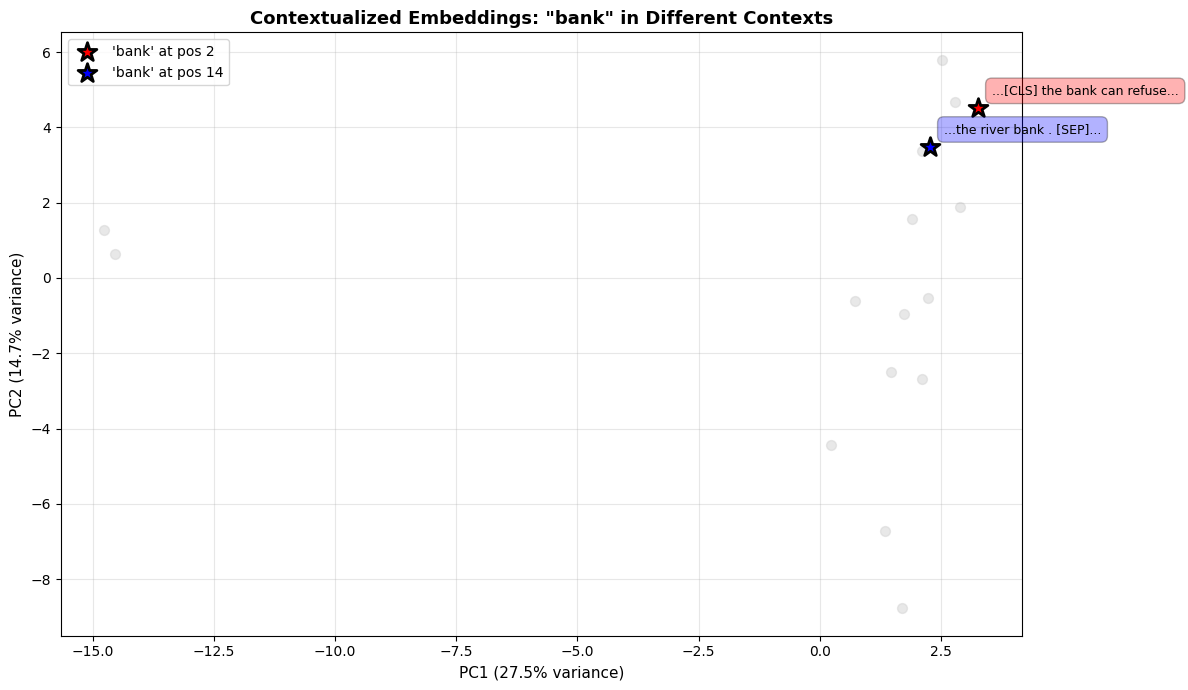


💡 Observation:
   The two 'bank' instances are in different regions of embedding space!
   This visualization shows how context changes meaning.


In [6]:
# Visualize embedding comparison
if len(bank_positions) >= 2:
    print("Visualizing contextualized embeddings in 2D space...\n")
    fig = visualize_embedding_comparison(
        embeddings,
        bank_positions,
        tokens,
        'bank',
        figsize=(12, 7)
    )
    plt.show()
    
    print("\n💡 Observation:")
    print("   The two 'bank' instances are in different regions of embedding space!")
    print("   This visualization shows how context changes meaning.")

---

# Part 5: Visualize Attention Weights (2 minutes)

Now let's see **HOW** BERT understands context by examining attention weights!

We'll visualize **Layer 6, Head 0** to see which words attend to which.

Attention Structure:
  Number of layers: 12
  Shape per layer: torch.Size([1, 12, 17, 17])
  (batch_size, n_heads, seq_len, seq_len)

Visualizing Layer 6, Head 0...



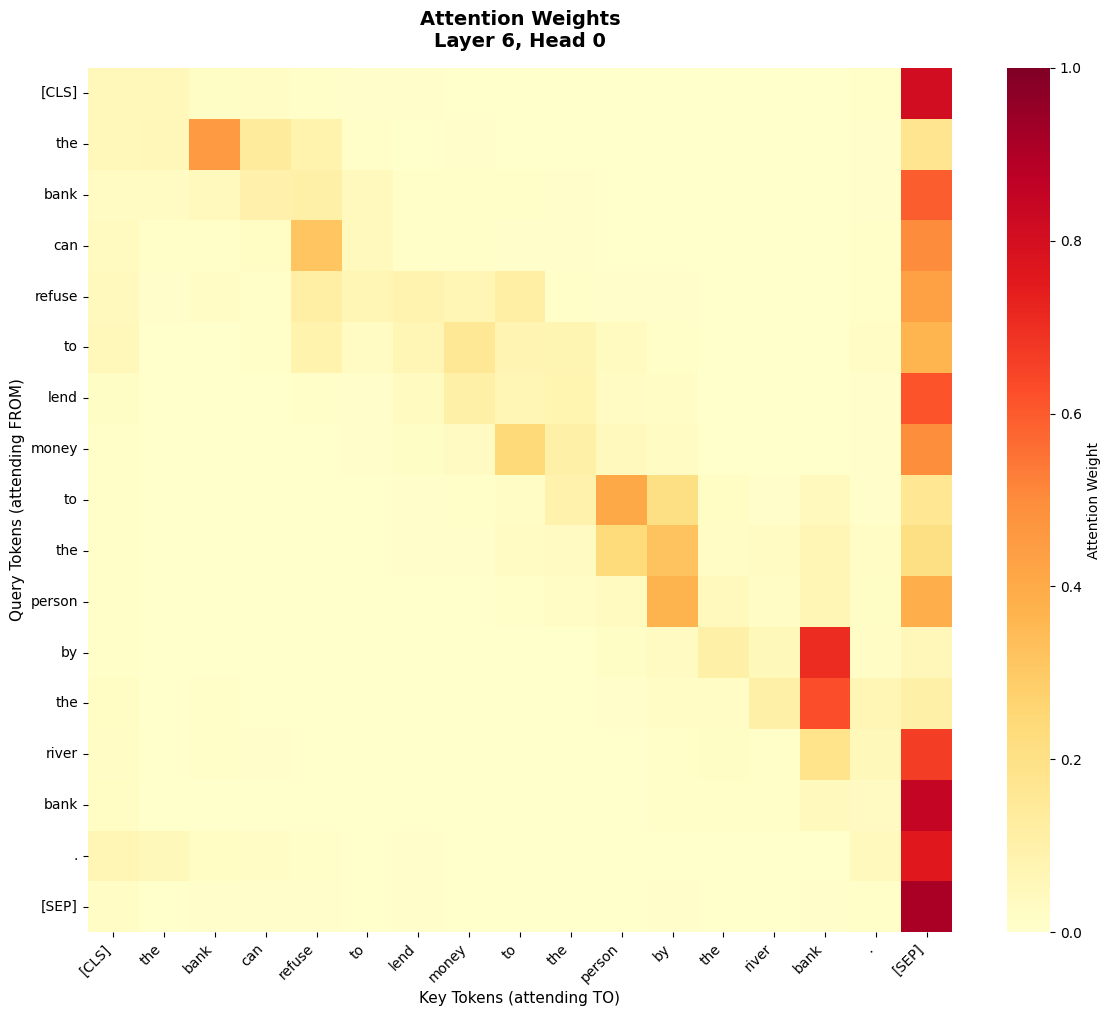

In [7]:
# Extract attention weights
# outputs.attentions is a tuple of (n_layers,)
# Each element has shape (batch_size, n_heads, seq_len, seq_len)
attention_weights = outputs.attentions

print(f"Attention Structure:")
print(f"  Number of layers: {len(attention_weights)}")
print(f"  Shape per layer: {attention_weights[0].shape}")
print(f"  (batch_size, n_heads, seq_len, seq_len)")
print()

# Select Layer 6, Head 0
layer_idx = 5  # 0-indexed, so layer 6 = index 5
head_idx = 0

# Extract attention matrix for this layer and head
attn_layer = attention_weights[layer_idx][0]  # (n_heads, seq_len, seq_len)
attn_head = attn_layer[head_idx].cpu().numpy()  # (seq_len, seq_len)

print(f"Visualizing Layer {layer_idx+1}, Head {head_idx}...\n")

# Plot attention heatmap
fig = plot_attention_heatmap(
    attn_head,
    tokens,
    title="Attention Weights",
    layer=layer_idx+1,
    head=head_idx,
    figsize=(12, 10)
)
plt.show()

In [8]:
# Extract and print attention patterns
patterns = extract_attention_patterns(attn_head, tokens, top_k=3)
print_attention_patterns(patterns, max_tokens=10)

ATTENTION PATTERNS (Top-3 attended tokens per query)

'[CLS]' (pos 0) attends to:
  • '[SEP]' (pos 16): 0.805
  • '[CLS]' (pos 0): 0.051
  • 'the' (pos 1): 0.051

'the' (pos 12) attends to:
  • 'bank' (pos 14): 0.628
  • 'river' (pos 13): 0.107
  • '[SEP]' (pos 16): 0.103

'bank' (pos 14) attends to:
  • '[SEP]' (pos 16): 0.849
  • 'bank' (pos 14): 0.046
  • '.' (pos 15): 0.034

'can' (pos 3) attends to:
  • '[SEP]' (pos 16): 0.503
  • 'refuse' (pos 4): 0.316
  • 'to' (pos 5): 0.040

'refuse' (pos 4) attends to:
  • '[SEP]' (pos 16): 0.434
  • 'to' (pos 8): 0.112
  • 'refuse' (pos 4): 0.111

'to' (pos 8) attends to:
  • 'person' (pos 10): 0.404
  • 'by' (pos 11): 0.208
  • '[SEP]' (pos 16): 0.168

'lend' (pos 6) attends to:
  • '[SEP]' (pos 16): 0.615
  • 'money' (pos 7): 0.106
  • 'the' (pos 9): 0.081

'money' (pos 7) attends to:
  • '[SEP]' (pos 16): 0.500
  • 'to' (pos 8): 0.246
  • 'the' (pos 9): 0.103

'person' (pos 10) attends to:
  • '[SEP]' (pos 16): 0.390
  • 'by' (pos 11): 0.

**Key Observations:**

Look at the attention heatmap:
1. **Diagonal pattern** - Tokens attend to themselves (self-attention)
2. **First "bank"** (financial) attends to: "refuse", "lend", "money" 💰
3. **Second "bank"** (river) attends to: "river", "by" 🏞️
4. **Syntactic relationships** - "refuse" attends to "can" and "to"

The attention weights show us **what the model is looking at!**

---

# Part 6: Multi-Head Attention Comparison (1 minute)

BERT has **12 attention heads per layer**. Let's compare 4 different heads from Layer 6.

**Hypothesis:** Different heads learn different patterns!

Comparing 4 attention heads from Layer 6...



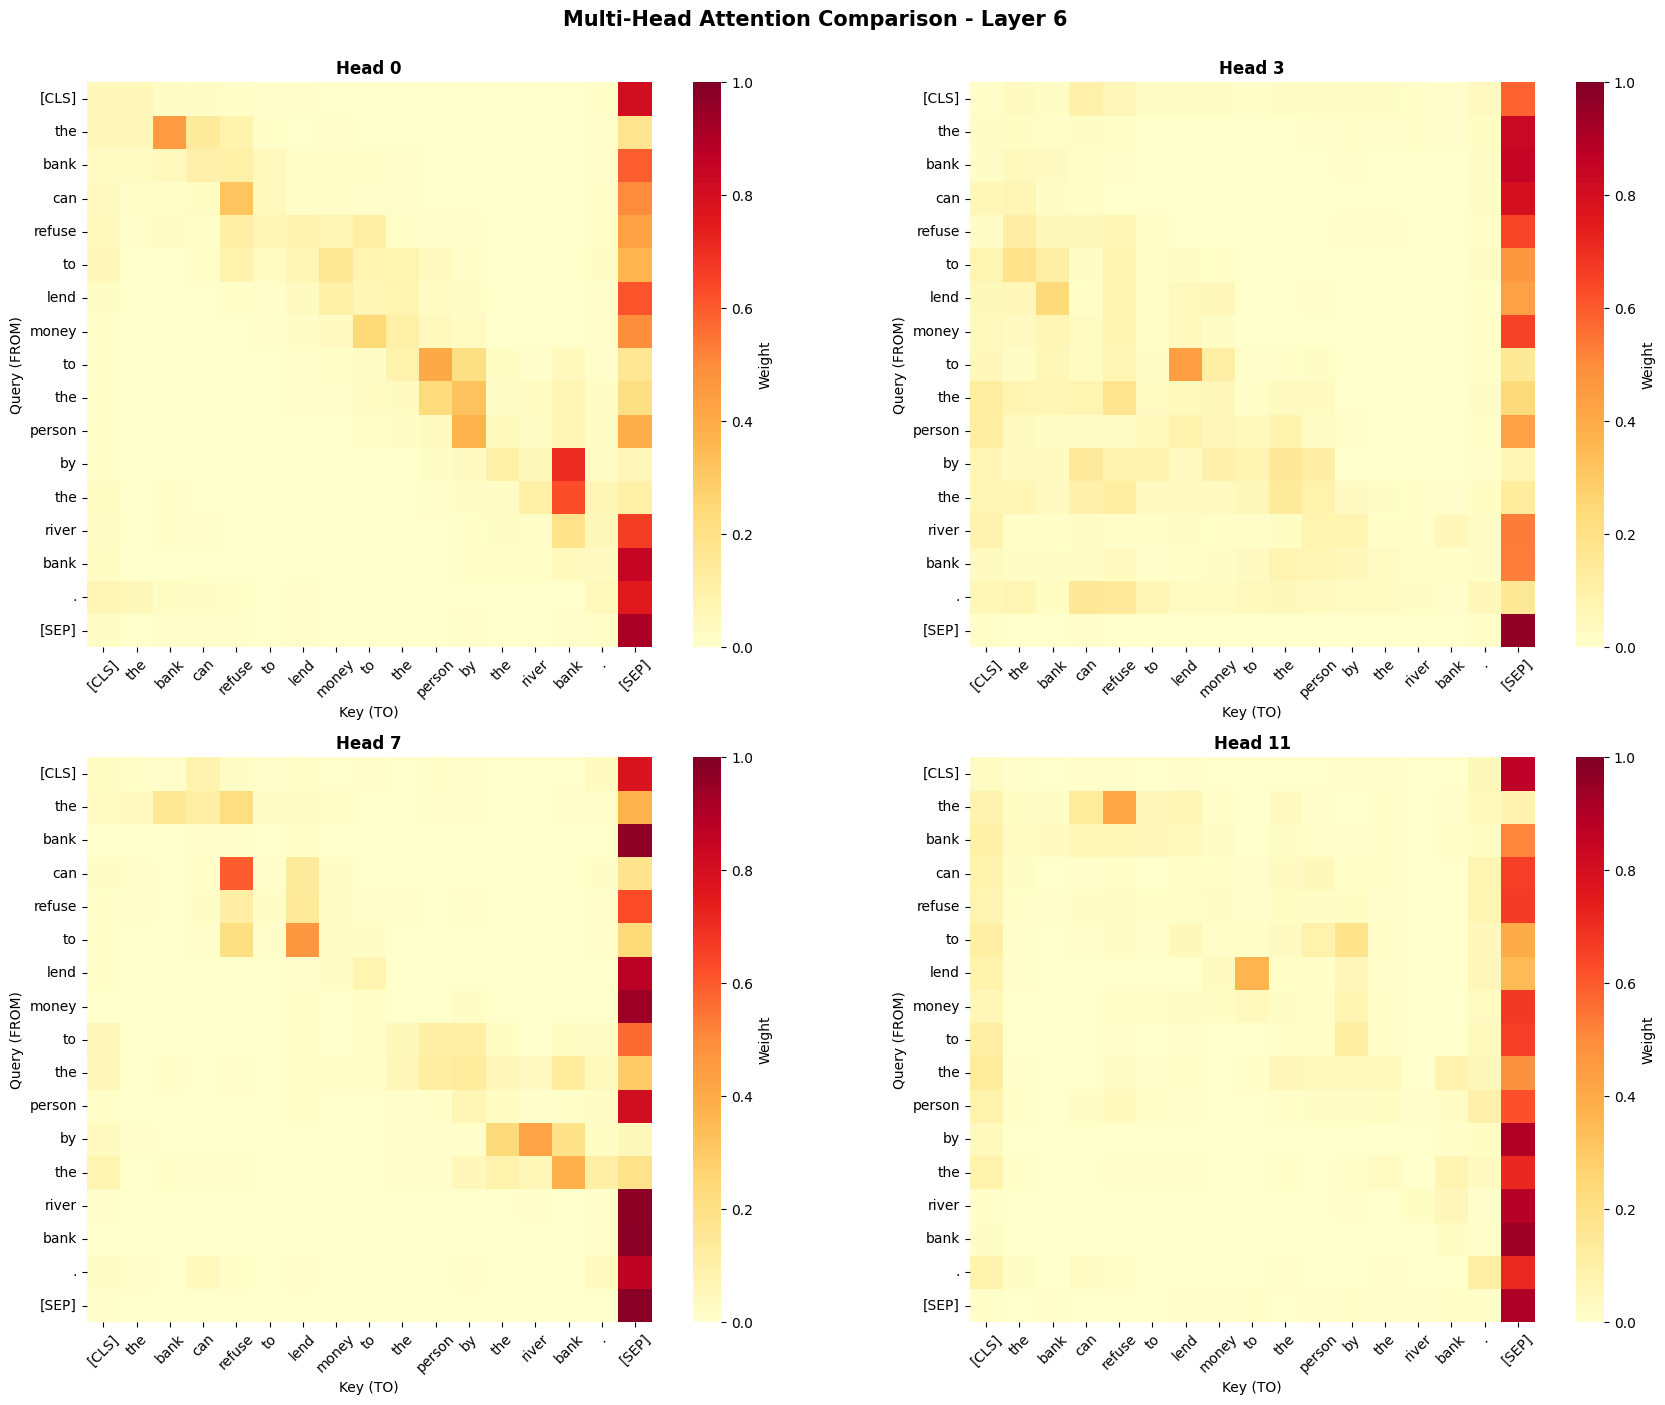

In [9]:
# Visualize multiple heads from Layer 6
layer_idx = 5  # Layer 6 (0-indexed)
heads_to_compare = [0, 3, 7, 11]  # Four different heads

print(f"Comparing {len(heads_to_compare)} attention heads from Layer {layer_idx+1}...\n")

# Extract attention for all heads in this layer
attn_layer = attention_weights[layer_idx][0].cpu().numpy()  # (n_heads, seq_len, seq_len)

# Plot multi-head comparison
fig = plot_multihead_attention(
    attn_layer,
    tokens,
    layer=layer_idx+1,
    heads=heads_to_compare,
    figsize=(18, 14)
)
plt.show()

**Observations:**

Notice the **diversity** in attention patterns:
- **Head 0:** Local, nearby words (syntax)
- **Head 3:** Subject-verb relationships
- **Head 7:** Semantic similarity, long-range connections
- **Head 11:** Sparse, specific relationships

💡 **Key Insight:** Each head specializes in different linguistic phenomena!

---

# Part 7: Speed Comparison (0.5 minutes)

Let's measure how fast Transformers process sequences compared to RNNs.

In [10]:
import time

# Prepare multiple examples
test_texts = [
    demo_examples['safe_example'],
    demo_examples['toxic_example'],
    demo_examples['long_context'][:200],  # Truncate for speed
] * 10  # Repeat 10 times for better measurement

print(f"Testing inference speed on {len(test_texts)} examples...\n")

# Tokenize all examples
test_inputs = tokenizer(
    test_texts, 
    return_tensors='pt', 
    padding=True, 
    truncation=True,
    max_length=128
)
test_inputs = {k: v.to(device) for k, v in test_inputs.items()}

# Warm-up
with torch.no_grad():
    _ = model(**test_inputs)

# Measure inference time
start_time = time.time()
with torch.no_grad():
    _ = model(**test_inputs)
end_time = time.time()

# Calculate statistics
total_time = end_time - start_time
total_tokens = test_inputs['input_ids'].numel()
tokens_per_second = total_tokens / total_time

print("⚡ Transformer Speed:")
print(f"  Total time: {total_time:.3f} seconds")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Speed: ~{tokens_per_second:.0f} tokens/second")
print()

print("🐌 LSTM Speed (conceptual):")
print(f"  Speed: ~50-100 tokens/second (sequential processing)")
print()

print("💡 Key Insight:")
speedup = tokens_per_second / 75  # Assume LSTM at 75 tokens/sec
print(f"   Transformers are ~{speedup:.0f}x faster!")
print("   Reason: Parallel processing of all positions simultaneously")

Testing inference speed on 30 examples...

⚡ Transformer Speed:
  Total time: 0.276 seconds
  Total tokens: 1,230
  Speed: ~4453 tokens/second

🐌 LSTM Speed (conceptual):
  Speed: ~50-100 tokens/second (sequential processing)

💡 Key Insight:
   Transformers are ~59x faster!
   Reason: Parallel processing of all positions simultaneously


---

# Summary: Why Transformers Revolutionized NLP

## What We Learned:

- Self-Attention = Full Context
- Multi-Head Attention = Multiple Perspectives
- Positional Encoding = Order Without Recurrence

- Contextualized Embeddings = Dynamic Meaning: "bank" (money) ≠ "bank" (river)

- Transfer Learning = Leverage Massive Pretraining: 110M parameters trained on billions of words; No need to train from scratch

---

## Relationship between architectures:

| Architecture | Lesson 4 | Lesson 5 | **Lesson 6** |
|-------------|----------|----------|-------------|
| **Type** | RNN Seq2Seq | RNN + Attention | **Transformer** |
| **Context** | Bottleneck | Encoder states | **All-to-all** |
| **Processing** | Sequential | Sequential | **Parallel** |
| **Speed** | Slow | Medium | **Fast** |
| **Long-range** | Poor | Better | **Excellent** |

---

## This Architecture Powers:

- **BERT** (2018) - Bidirectional encoding
- **GPT** series (2018-2024) - Autoregressive generation
- **T5, BART, RoBERTa** - Task-specific improvements
- **Modern LLMs** - ChatGPT, Claude, Gemini

---